In [1]:
# encoding=utf8
import sys

# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
from afinn import Afinn

reload(sys)
sys.setdefaultencoding('utf8')

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Entrenamieto_ECI_2020.csv')
data.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,"5,272,800.00",EUR,"5,272,800.00",Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,"48,230.00",EUR,"48,230.00",Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,"83,865.60",USD,"83,865.60",Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,"7,421,881.50",USD,"7,421,881.50",Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,"13,357,192.50",USD,"13,357,192.50",Closed Lost,Prod_Category_A_None


In [3]:
data.shape

(16947, 52)

In [4]:
data.size

881244

In [5]:
data.count()

ID                                    16947
Region                                16947
Territory                             16947
Pricing, Delivery_Terms_Quote_Appr    16947
Pricing, Delivery_Terms_Approved      16947
Bureaucratic_Code_0_Approval          16947
Bureaucratic_Code_0_Approved          16947
Submitted_for_Approval                16947
Bureaucratic_Code                     16947
Account_Created_Date                  16947
Source                                16947
Billing_Country                       16947
Account_Name                          16947
Opportunity_Name                      16947
Opportunity_ID                        16947
Sales_Contract_No                     16947
Account_Owner                         16947
Opportunity_Owner                     16947
Account_Type                          16947
Opportunity_Type                      16947
Quote_Type                            16947
Delivery_Terms                        16947
Opportunity_Created_Date        

In [6]:
data_by_region = data.groupby(['Region','Stage']).size().reset_index(name='count')
data_by_region
#repeated = data_by_region[data_by_region['count']>1].sort_values(by='count', ascending=False)
#repeated[repeated.target==1].describe()

,Region,Stage,count
0,APAC,Closed Lost,1355
1,APAC,Closed Won,1896
2,APAC,Proposal,8
3,APAC,Qualification,3
4,Americas,Closed Lost,2140
5,Americas,Closed Won,1793
6,Americas,Negotiation,8
7,Americas,Proposal,4
8,EMEA,Closed Lost,2189
9,EMEA,Closed Won,2471


In [7]:
data['Total_Taxable_Amount_Currency'].unique()

array(['EUR', 'USD', 'JPY', 'AUD', 'GBP'], dtype=object)

In [8]:
data['Total_Amount'] = data['Total_Amount'].fillna(0)
data[data['Total_Amount'].isnull()]['Total_Amount']

Series([], Name: Total_Amount, dtype: float64)

In [9]:
#data['Total_Amount'] = data['Total_Amount'].fillna(0)
data[data['Total_Taxable_Amount'].isnull()]['Total_Taxable_Amount']

Series([], Name: Total_Taxable_Amount, dtype: float64)

In [10]:
pd.to_datetime(data['Month']).dt.year.unique()

array([2016, 2018, 2017, 2019, 2020], dtype=int64)

In [11]:
#data['Total_Amount_Currency'] = data['Total_Amount_Currency'].astype(str)
#data['Total_Amount_Currency'].map(lambda x:  type(x))

In [12]:
# https://data.oecd.org/conversion/exchange-rates.htm
price_usd_convertion_by_year = {
    'EUR': {2016: 0.940, 2017: 0.923, 2018: 0.848, 2019: 0.893, 2020: 0.860},
    'JPY': {2016: 113.138, 2017: 116.667, 2018: 110.424, 2019: 109.008, 2020: 104.66},
    'AUD': {2016: 1.400, 2017: 1.358, 2018: 1.340, 2019: 1.439, 2020: 1.420},
    'GBP': {2016: 0.770, 2017: 0.808, 2018: 0.750, 2019: 0.784, 2020: 0.770},
    'USD': {2016: 1, 2017: 1, 2018: 1, 2019: 1, 2020: 1}
}

def get_convertion_usd(x):
    currency = x['Total_Amount_Currency']
    year = pd.to_datetime(x['Month']).year
    return price_usd_convertion_by_year[currency][year]
    
data['Total_Amount_USD'] = data['Total_Amount'] / data.apply(lambda x: get_convertion_usd(x), axis=1)

data['Total_Amount_USD'].head()

0           5,609,361.70
1              51,308.51
2              83,865.60
3           7,421,881.50
4          13,357,192.50
Name: Total_Amount_USD, dtype: float64

In [13]:
"""
Descripcion de la columna Total_Amount_USD de a cuerdo a distintos parametros
"""
data['Total_Amount_USD'].describe()

count              16,947.00
mean              990,804.94
std             5,772,734.01
min                     0.00
25%                 4,107.18
50%                77,910.00
75%               281,702.63
max           315,000,081.90
Name: Total_Amount_USD, dtype: float64

In [14]:
describe_lost = data[data['Stage'] == "Closed Lost"]['Total_Amount_USD'].describe()
describe_lost

count               7,350.00
mean            2,051,760.23
std             8,606,069.37
min                     0.00
25%                33,486.59
50%               196,560.00
75%             1,061,984.81
max           315,000,081.90
Name: Total_Amount_USD, dtype: float64

In [15]:
describe_won = data[data['Stage'] == "Closed Won"]['Total_Amount_USD'].describe()
describe_won

count               9,533.00
mean              172,937.45
std               759,335.96
min                     0.00
25%                 2,300.00
50%                38,003.00
75%                94,899.76
max            27,315,253.35
Name: Total_Amount_USD, dtype: float64

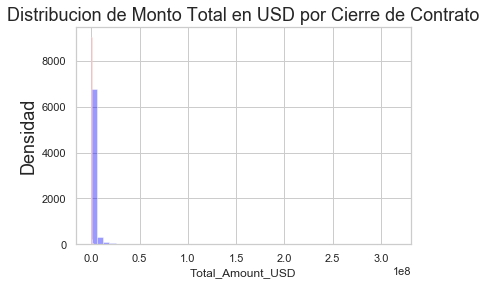

In [16]:
g = sns.distplot(data[data['Stage'] == "Closed Lost"]['Total_Amount_USD'], color="blue", label='Closed Lost', kde=False)
g = sns.distplot(data[data['Stage'] == "Closed Won"]['Total_Amount_USD'], color="red", label='Closed Won', kde=False)
g.set_title("Distribucion de Monto Total en USD por Cierre de Contrato", fontsize=18)
g.set_ylabel("Densidad", fontsize=18)
plt.rcParams['figure.figsize']=(10,10)

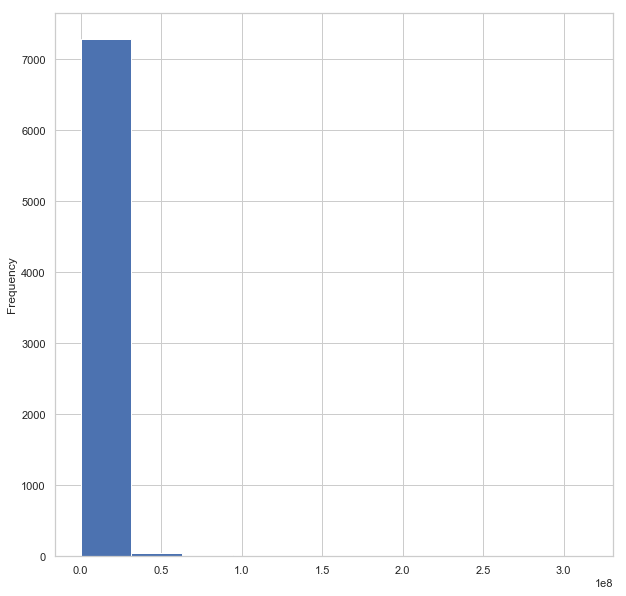

In [17]:
data[data['Stage'] == "Closed Lost"]['Total_Amount_USD'].plot(kind='hist')

In [54]:
"""
Descripcion de monto de contratos cerrados
"""
closed_contracts = data[ (data['Stage'] == "Closed Lost") | (data['Stage'] == "Closed Won") ]

In [55]:
closed_contracts.shape

(16883, 56)

Text(0,0.5,'Total_Amount_USD')

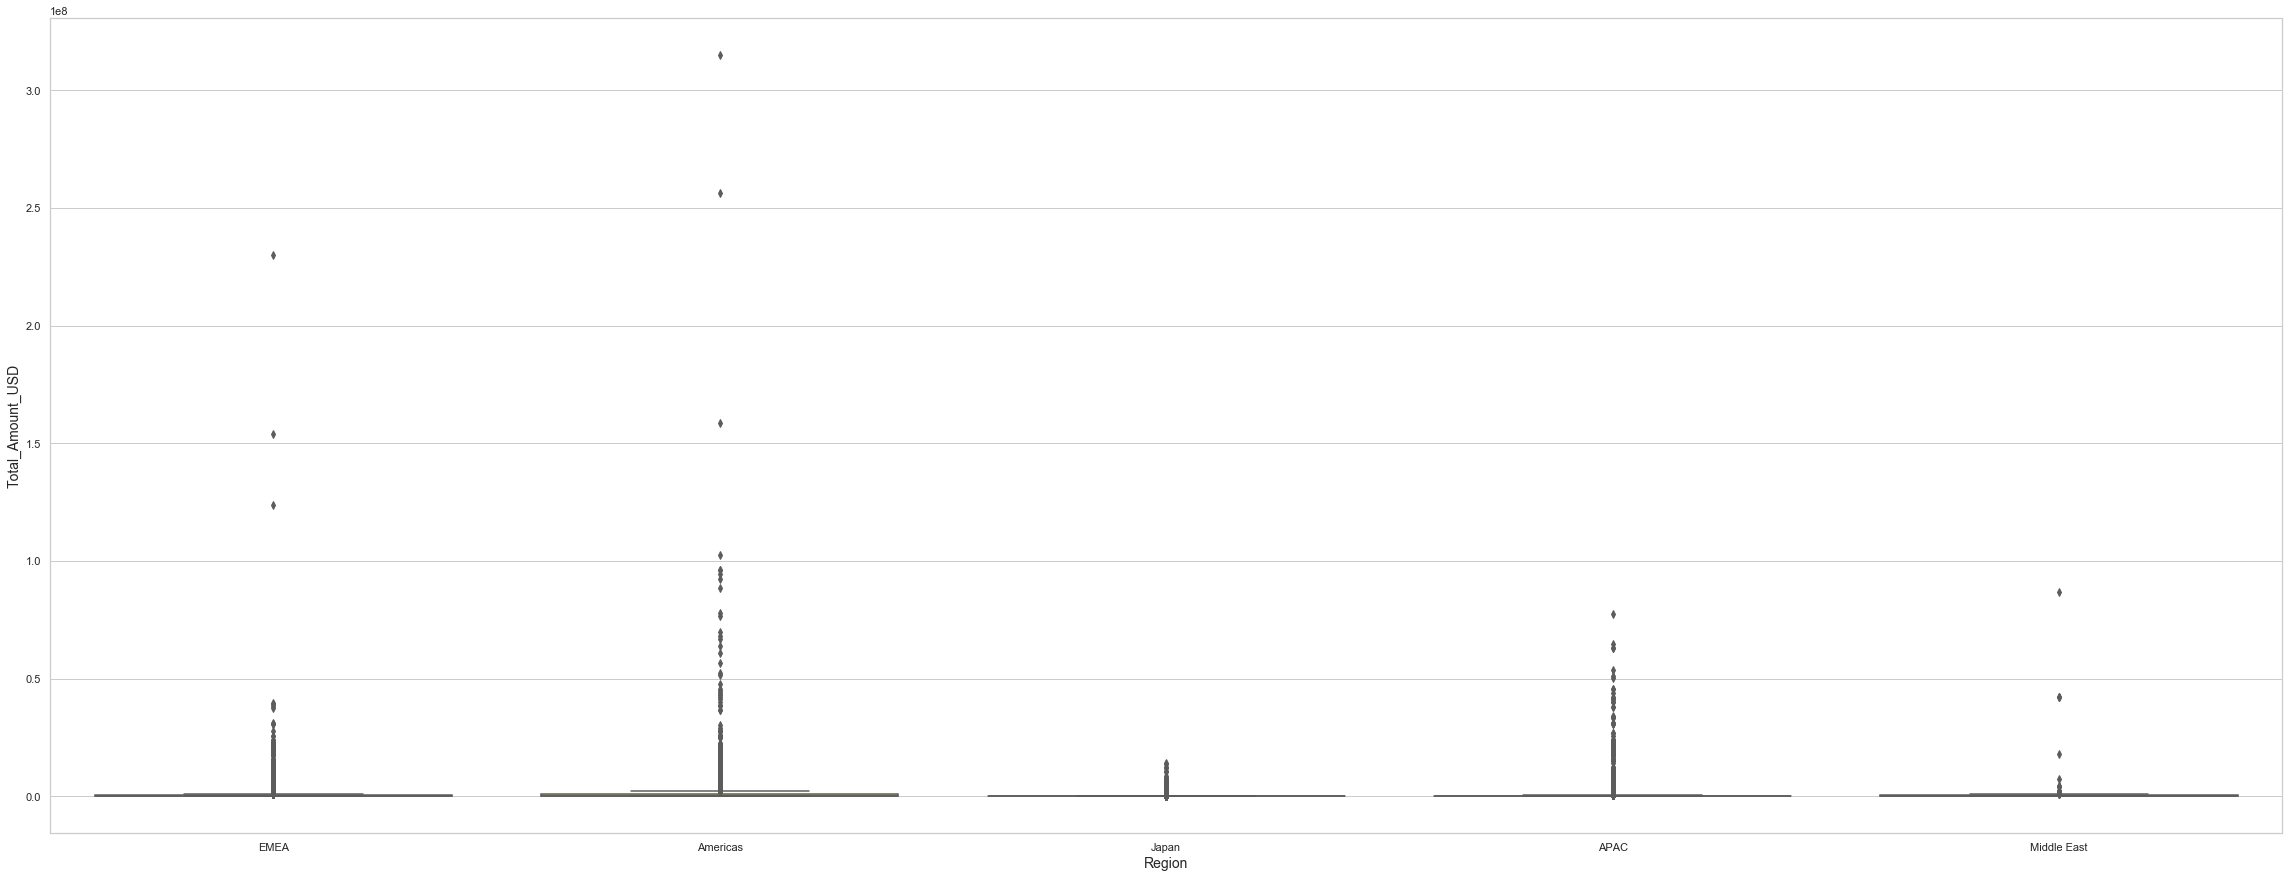

In [56]:
g = sns.boxplot(x="Region", y="Total_Amount_USD", 
                     data=closed_contracts, palette="hls")
g.set_title("", fontsize=18)
g.set_xlabel("Region", fontsize=14)
g.set_ylabel("Total_Amount_USD", fontsize=14)

Text(0,0.5,'Total_Amount_USD')

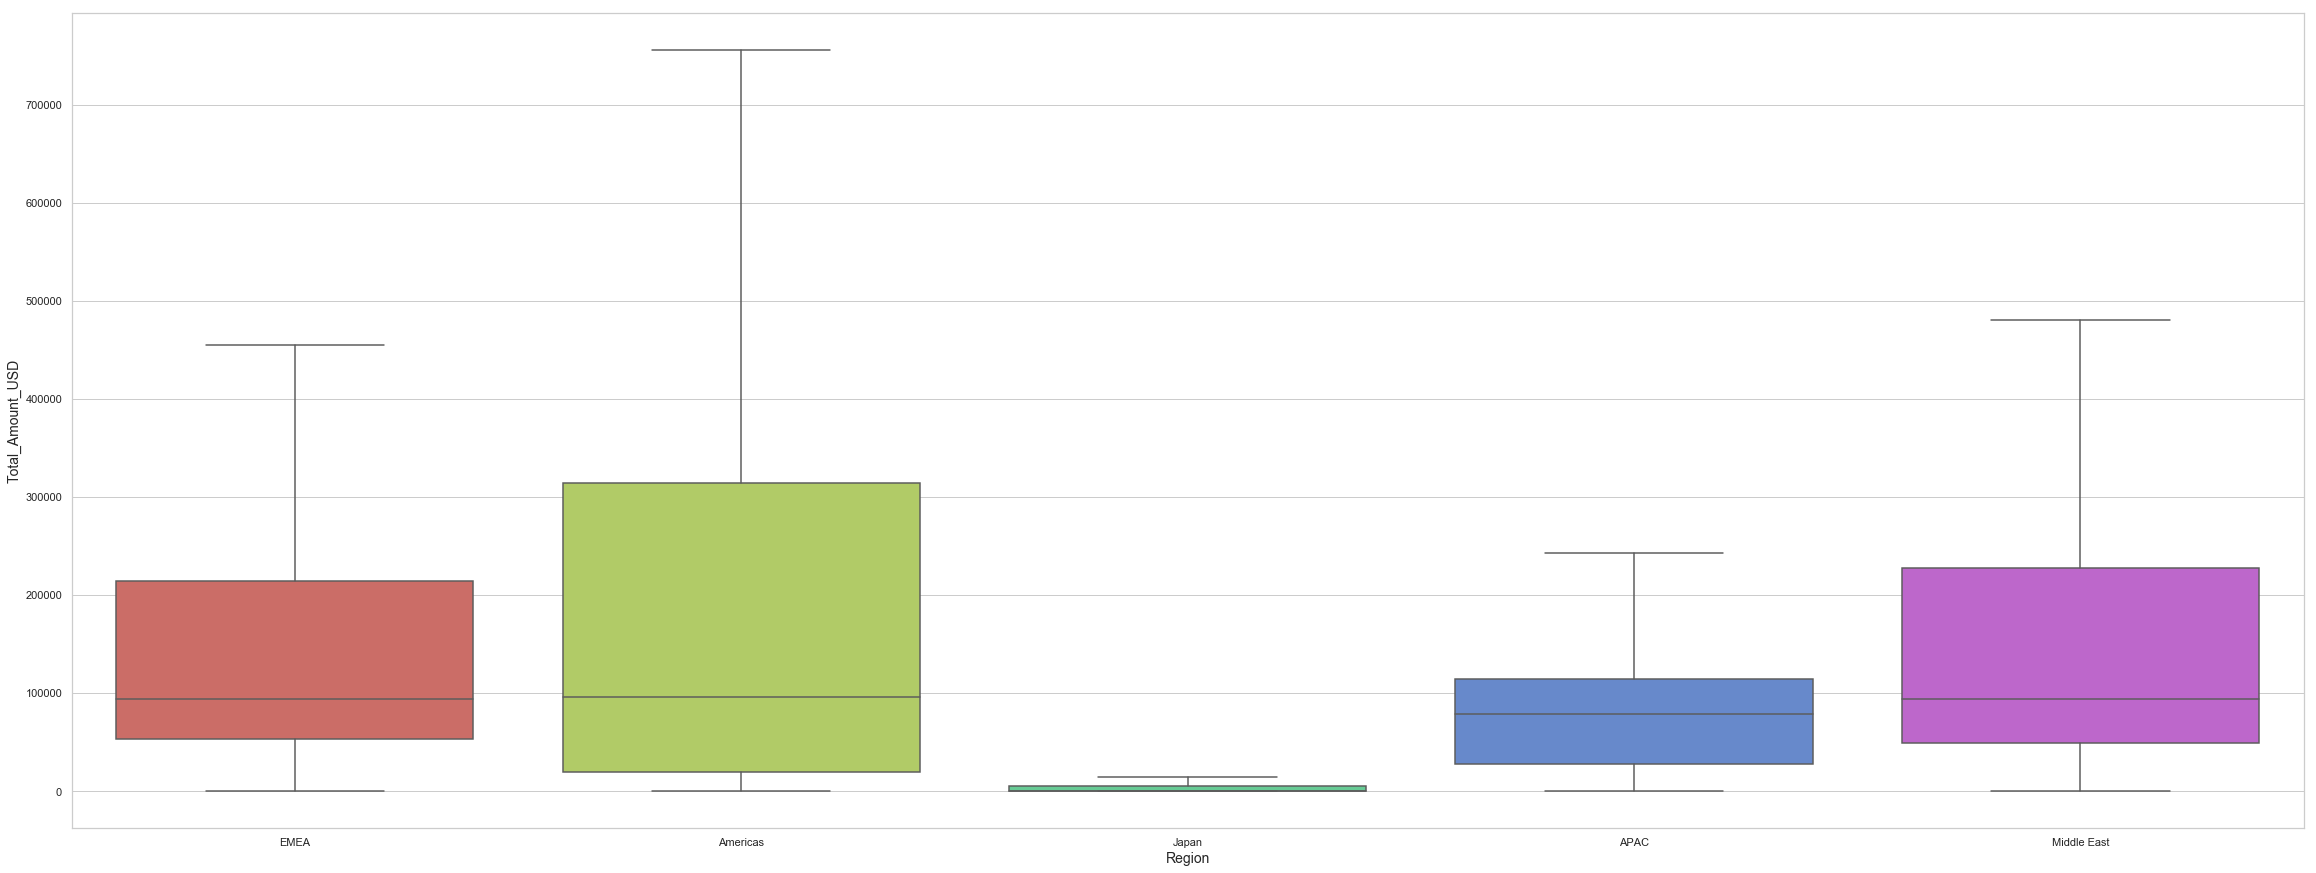

In [60]:
closed_contracts_filtered = closed_contracts[closed_contracts['Total_Amount_USD'] < 1000000]
g = sns.boxplot(x="Region", y="Total_Amount_USD", 
                     data=closed_contracts_filtered, palette="hls", showfliers=False)
g.set_title("", fontsize=18)
g.set_xlabel("Region", fontsize=14)
g.set_ylabel("Total_Amount_USD", fontsize=14)

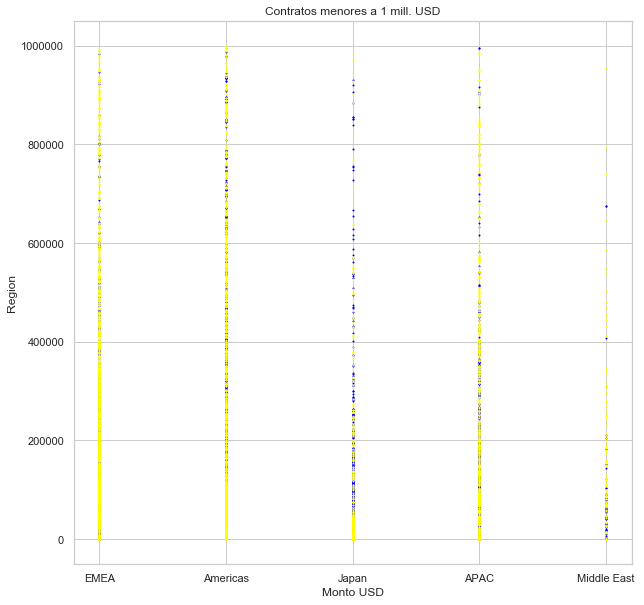

In [22]:
closed_contracts_filtered_closed_lost = closed_contracts_filtered[closed_contracts_filtered['Stage'] == 'Closed Lost']
closed_contracts_filtered_closed_won = closed_contracts_filtered[closed_contracts_filtered['Stage'] == 'Closed Won']

lost_normal = closed_contracts_filtered_closed_lost["Total_Amount_USD"].max()
won_normal = closed_contracts_filtered_closed_won["Total_Amount_USD"].max()

fig, ax = plt.subplots()
ax.scatter(closed_contracts_filtered_closed_won["Region"], closed_contracts_filtered_closed_won["Total_Amount_USD"],
          label="Contrato Ganado", color="blue", s = 1)
ax.scatter(closed_contracts_filtered_closed_lost["Region"], closed_contracts_filtered_closed_lost["Total_Amount_USD"],
          label="Contrato Lost", color="yellow", s = 1)
plt.title("Contratos menores a 1 mill. USD")
plt.xlabel("Monto USD")
plt.ylabel("Region")
plt.show()

Text(0,0.5,'Total_Amount_USD')

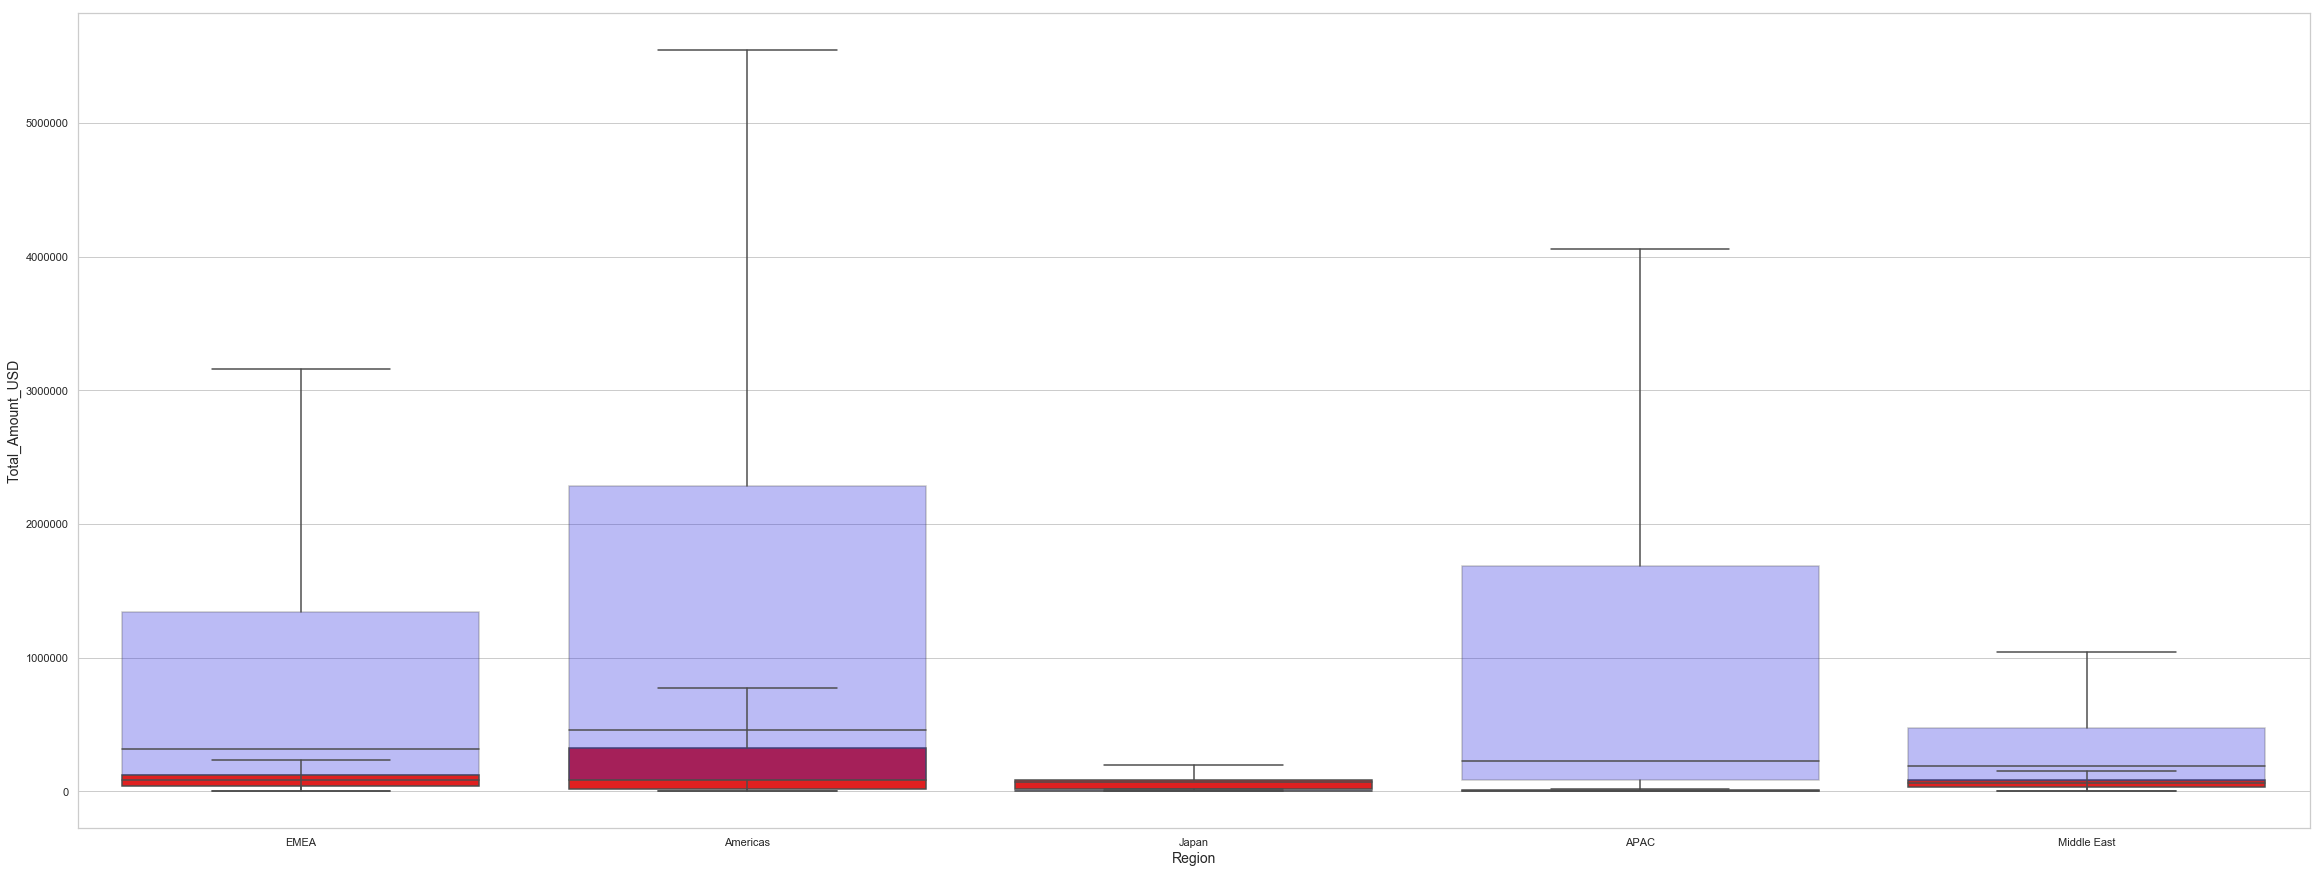

In [68]:
closed_contracts_closed_lost = closed_contracts[closed_contracts['Stage'] == 'Closed Lost']
closed_contracts_closed_won = closed_contracts[closed_contracts['Stage'] == 'Closed Won']

g = sns.boxplot(x="Region", y="Total_Amount_USD", data=closed_contracts_closed_won, color="red", showfliers=False)

g = sns.boxplot(x="Region", y="Total_Amount_USD", data=closed_contracts_closed_lost, color="blue", showfliers=False, 
               boxprops=dict(alpha=.3))

g.set_title("", fontsize=18)
g.set_xlabel("Region", fontsize=14)
g.set_ylabel("Total_Amount_USD", fontsize=14)

In [23]:
data_by_region = data.groupby(['Region','Stage']).size()
data_by_region = data_by_region.unstack().reset_index().fillna(0)
data_by_region

Stage,Region,Closed Lost,Closed Won,Negotiation,Proposal,Qualification
0,APAC,"1,355.00","1,896.00",0.00,8.00,3.00
1,Americas,"2,140.00","1,793.00",8.00,4.00,0.00
2,EMEA,"2,189.00","2,471.00",1.00,3.00,0.00
3,Japan,"1,546.00","3,323.00",1.00,14.00,8.00
4,Middle East,120.00,50.00,8.00,6.00,0.00


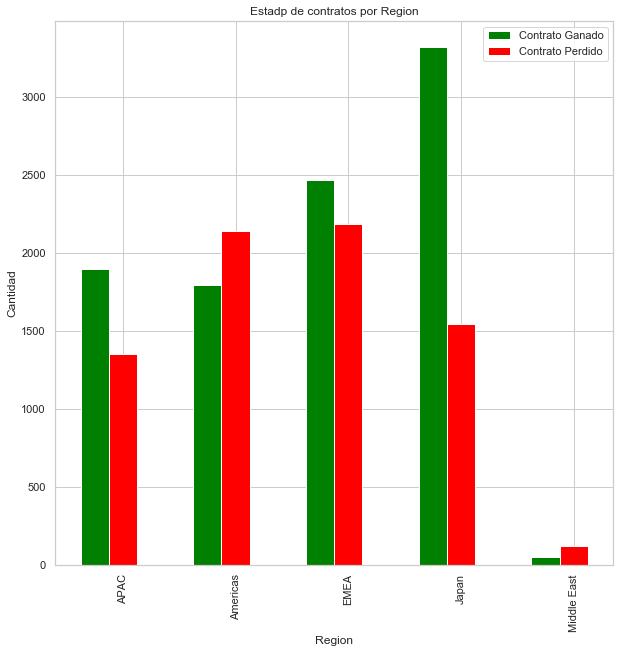

In [24]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_region.shape[0])
width = 0.25

c_won = data_by_region["Closed Won"].to_numpy()
c_lost = data_by_region["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_region['Region'], rotation='vertical')
plt.title("Estadp de contratos por Region")
plt.xlabel("Region")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

In [25]:
data.loc[data['Territory'] == 'None', 'Territory'] = data['Billing_Country']
data[data['Territory'] == 'None']['Territory'].head()

3063     None
16144    None
Name: Territory, dtype: object

In [26]:
parsed_territories = data.loc[data['Territory'] != 'None', :]
parsed_territories.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Total_Amount_USD
0,27761,EMEA,Netherlands,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,2016,NaT,10,EUR,"5,272,800.00",EUR,"5,272,800.00",Closed Lost,Prod_Category_A_None,"5,609,361.70"
1,27760,EMEA,Netherlands,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,2016,NaT,0,EUR,"48,230.00",EUR,"48,230.00",Closed Won,Prod_Category_A_None,"51,308.51"
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,2016,NaT,0,USD,"83,865.60",USD,"83,865.60",Closed Won,Prod_Category_A_None,"83,865.60"
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,2018,NaT,14,USD,"7,421,881.50",USD,"7,421,881.50",Closed Lost,Prod_Category_A_None,"7,421,881.50"
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,2018,NaT,25,USD,"13,357,192.50",USD,"13,357,192.50",Closed Lost,Prod_Category_A_None,"13,357,192.50"


In [27]:
territories_count = parsed_territories.groupby(['Territory', 'Stage'])['ID'].count()
territories_unstacked = territories_count.unstack().reset_index().rename(columns={"ID": "count"}).fillna(0)
#territories_count = parsed_territories.groupby(['Territory', 'Stage'])['ID'].agg({'count'})
#territories_unstacked = territories_count.unstack().fillna(0)
#territories_unstacked.columns = territories_unstacked.columns.droplevel()
territories_unstacked.columns.name = ""
territories_unstacked.head()

,Territory,Closed Lost,Closed Won,Negotiation,Proposal,Qualification
0,Albania,3.00,0.00,0.00,0.00,0.00
1,Armenia,2.00,0.00,0.00,0.00,0.00
2,Australia,506.00,696.00,0.00,4.00,2.00
3,Austria,21.00,124.00,0.00,0.00,0.00
4,Belarus,4.00,0.00,0.00,0.00,0.00


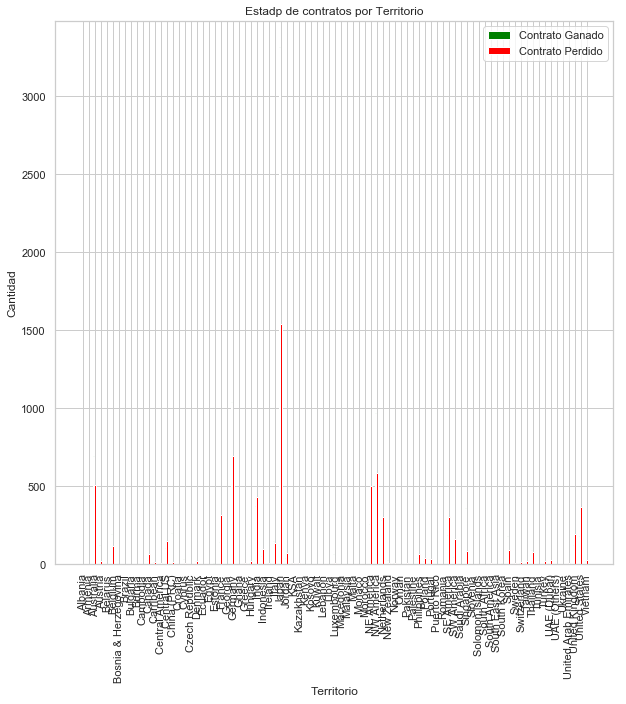

In [28]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(territories_unstacked.shape[0])
width = 0.25

c_won = territories_unstacked["Closed Won"].to_numpy()
c_lost = territories_unstacked["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(territories_unstacked['Territory'], rotation='vertical')
plt.title("Estadp de contratos por Territorio")
plt.xlabel("Territorio")
plt.ylabel("Cantidad")
ax.legend()
plt.rcParams['figure.figsize'] = [40, 15]
plt.show()

In [29]:
territories_unstacked['Closed'] = territories_unstacked['Closed Won'] + territories_unstacked['Closed Lost']
territories_unstacked.head()

,Territory,Closed Lost,Closed Won,Negotiation,Proposal,Qualification,Closed
0,Albania,3.00,0.00,0.00,0.00,0.00,3.00
1,Armenia,2.00,0.00,0.00,0.00,0.00,2.00
2,Australia,506.00,696.00,0.00,4.00,2.00,"1,202.00"
3,Austria,21.00,124.00,0.00,0.00,0.00,145.00
4,Belarus,4.00,0.00,0.00,0.00,0.00,4.00


In [30]:
territories_gt_100_contracts = territories_unstacked[territories_unstacked['Closed'] >= 100].sort_values(by=['Closed'], ascending=False)
territories_gt_100_contracts.head()

,Territory,Closed Lost,Closed Won,Negotiation,Proposal,Qualification,Closed
33,Japan,"1,543.00","3,319.00",1.00,14.00,8.00,"4,862.00"
25,Germany,698.00,"1,040.00",0.00,0.00,0.00,"1,738.00"
49,NW America,587.00,973.00,8.00,0.00,0.00,"1,560.00"
2,Australia,506.00,696.00,0.00,4.00,2.00,"1,202.00"
29,India,434.00,374.00,0.00,1.00,1.00,808.00


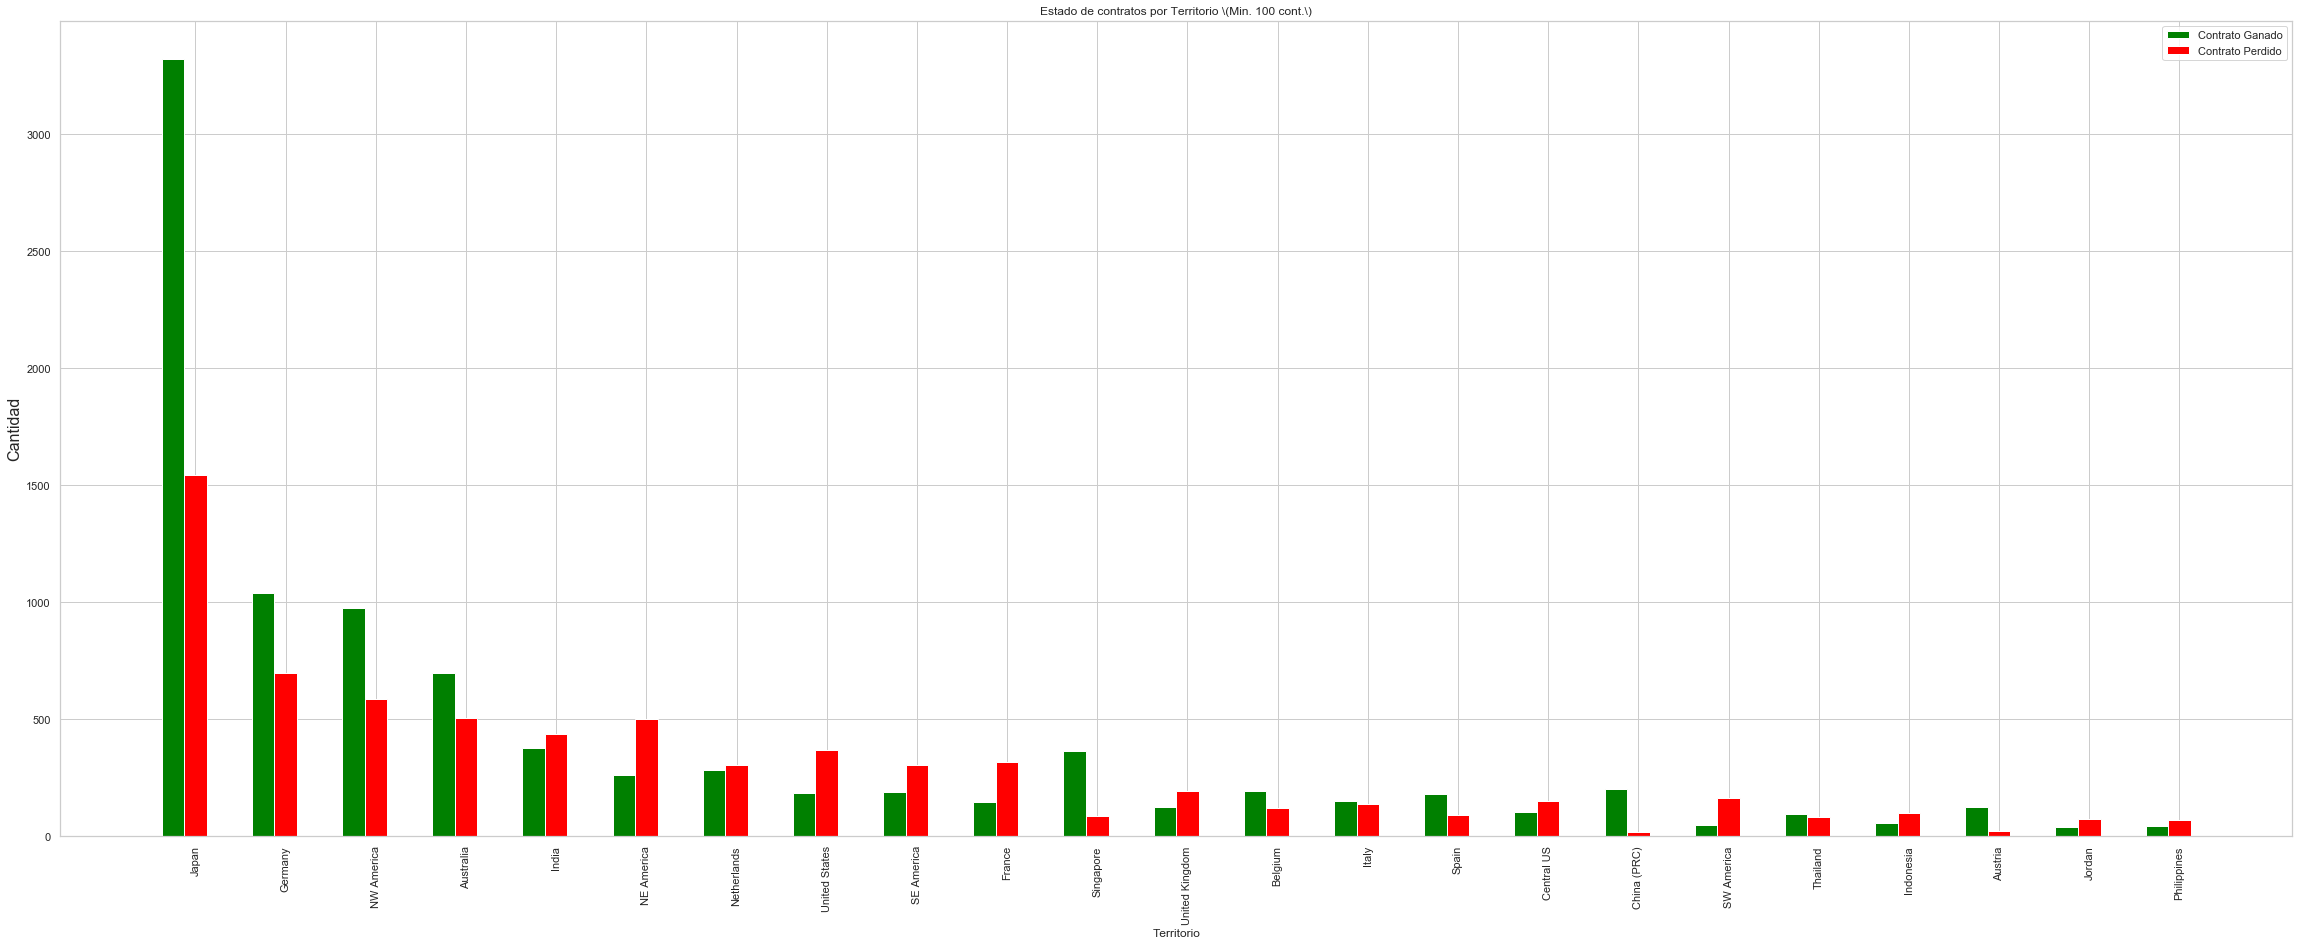

In [31]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(territories_gt_100_contracts.shape[0])
width = 0.25

c_won = territories_gt_100_contracts["Closed Won"].to_numpy()
c_lost = territories_gt_100_contracts["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(territories_gt_100_contracts['Territory'], rotation='vertical')
plt.title("Estado de contratos por Territorio \(Min. 100 cont.\)")
plt.xlabel("Territorio", fontsize='large')
plt.ylabel("Cantidad", fontsize=16)
ax.legend()
plt.rcParams['figure.figsize'] = [40, 15]
plt.show()

In [32]:
"""
Analisis de tiempo
"""

data['Number_Month'] = pd.to_datetime(data['Month']).dt.month
data['Number_Month'].head()

0    5
1    1
2    1
3    2
4    2
Name: Number_Month, dtype: int64

In [33]:
data['Number_Year'] = pd.to_datetime(data['Month']).dt.year
data['Number_Year'].head()

0    2016
1    2016
2    2016
3    2018
4    2018
Name: Number_Year, dtype: int64

In [34]:
closed_contracts = data[ ((data['Stage'] == "Closed Lost") | (data['Stage'] == "Closed Won")) & 
                        ((data['Region'] == "Japan") | (data['Region'] == "EMEA")) ]

data_by_region_and_month = closed_contracts.groupby(['Region','Number_Month','Stage']).size()
data_by_region_and_month = data_by_region_and_month.unstack().reset_index().fillna(0)
data_by_region_and_month

Stage,Region,Number_Month,Closed Lost,Closed Won
0,EMEA,1,172,196
1,EMEA,2,134,164
2,EMEA,3,164,243
3,EMEA,4,233,214
4,EMEA,5,185,247
5,EMEA,6,176,255
6,EMEA,7,212,207
7,EMEA,8,188,165
8,EMEA,9,167,237
9,EMEA,10,241,218


In [35]:
data_by_japan_and_month = data_by_region_and_month[data_by_region_and_month['Region'] == 'Japan']
del data_by_japan_and_month['Region']
data_by_japan_and_month

Stage,Number_Month,Closed Lost,Closed Won
12,1,39,256
13,2,291,304
14,3,414,262
15,4,116,353
16,5,137,287
17,6,144,239
18,7,40,234
19,8,110,175
20,9,125,242
21,10,59,351


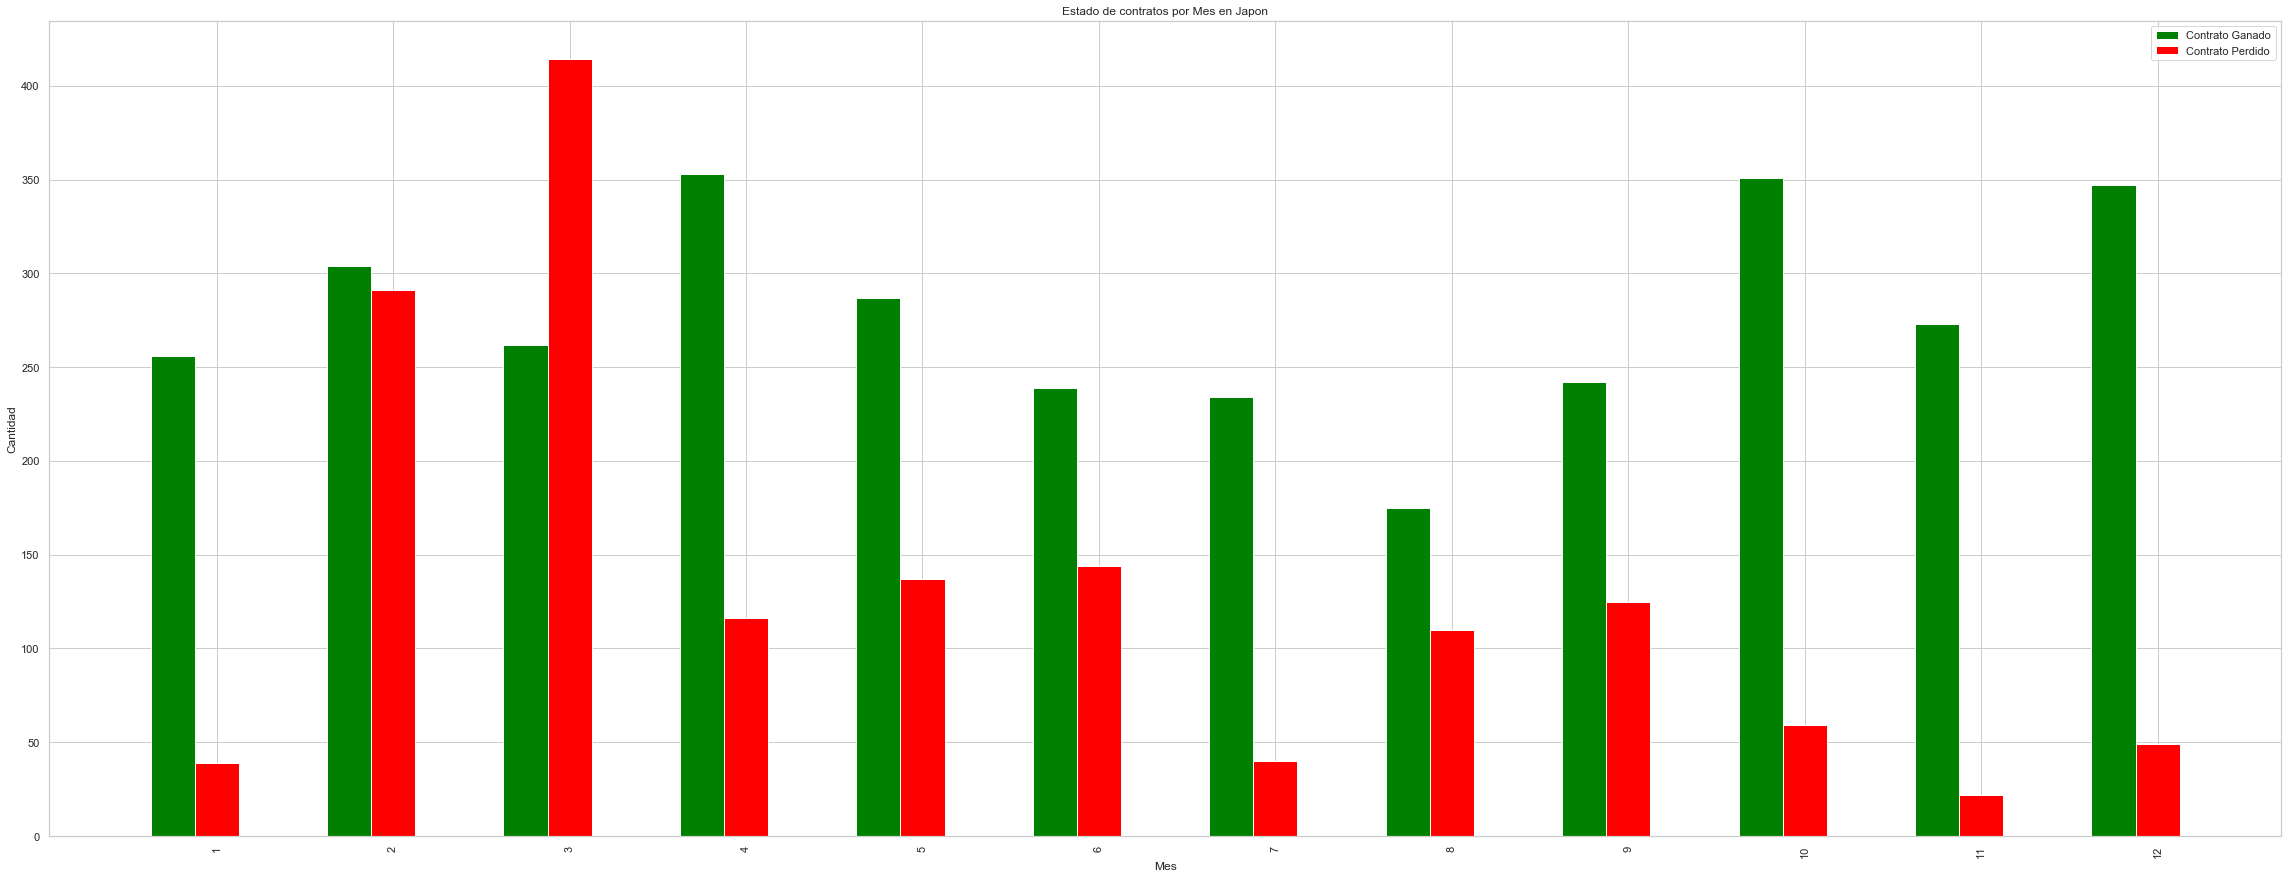

In [36]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_japan_and_month.shape[0])
width = 0.25

c_won = data_by_japan_and_month["Closed Won"].to_numpy()
c_lost = data_by_japan_and_month["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_japan_and_month['Number_Month'], rotation='vertical')
plt.title("Estado de contratos por Mes en Japon")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

In [37]:
data_by_emea_and_month = data_by_region_and_month[data_by_region_and_month['Region'] == 'EMEA']
del data_by_emea_and_month['Region']
data_by_emea_and_month

Stage,Number_Month,Closed Lost,Closed Won
0,1,172,196
1,2,134,164
2,3,164,243
3,4,233,214
4,5,185,247
5,6,176,255
6,7,212,207
7,8,188,165
8,9,167,237
9,10,241,218


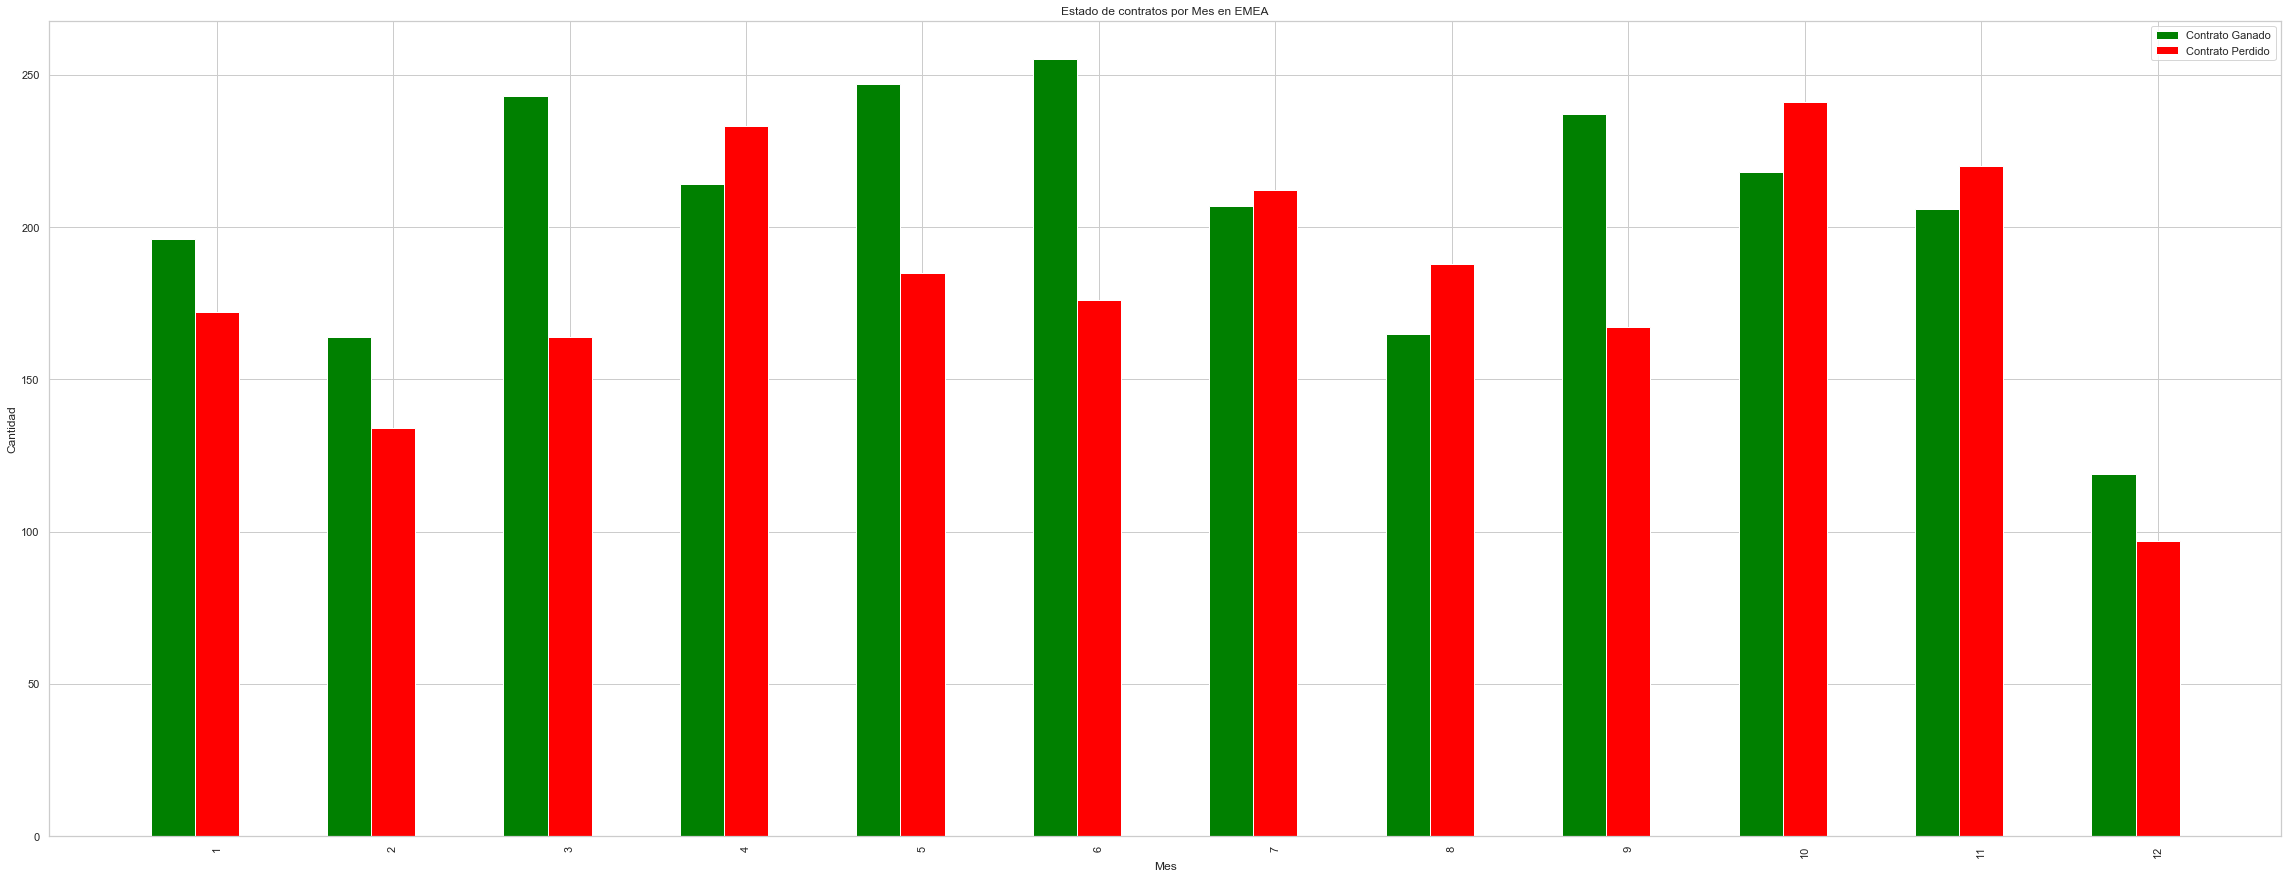

In [38]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_emea_and_month.shape[0])
width = 0.25

c_won = data_by_emea_and_month["Closed Won"].to_numpy()
c_lost = data_by_emea_and_month["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_emea_and_month['Number_Month'], rotation='vertical')
plt.title("Estado de contratos por Mes en EMEA")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

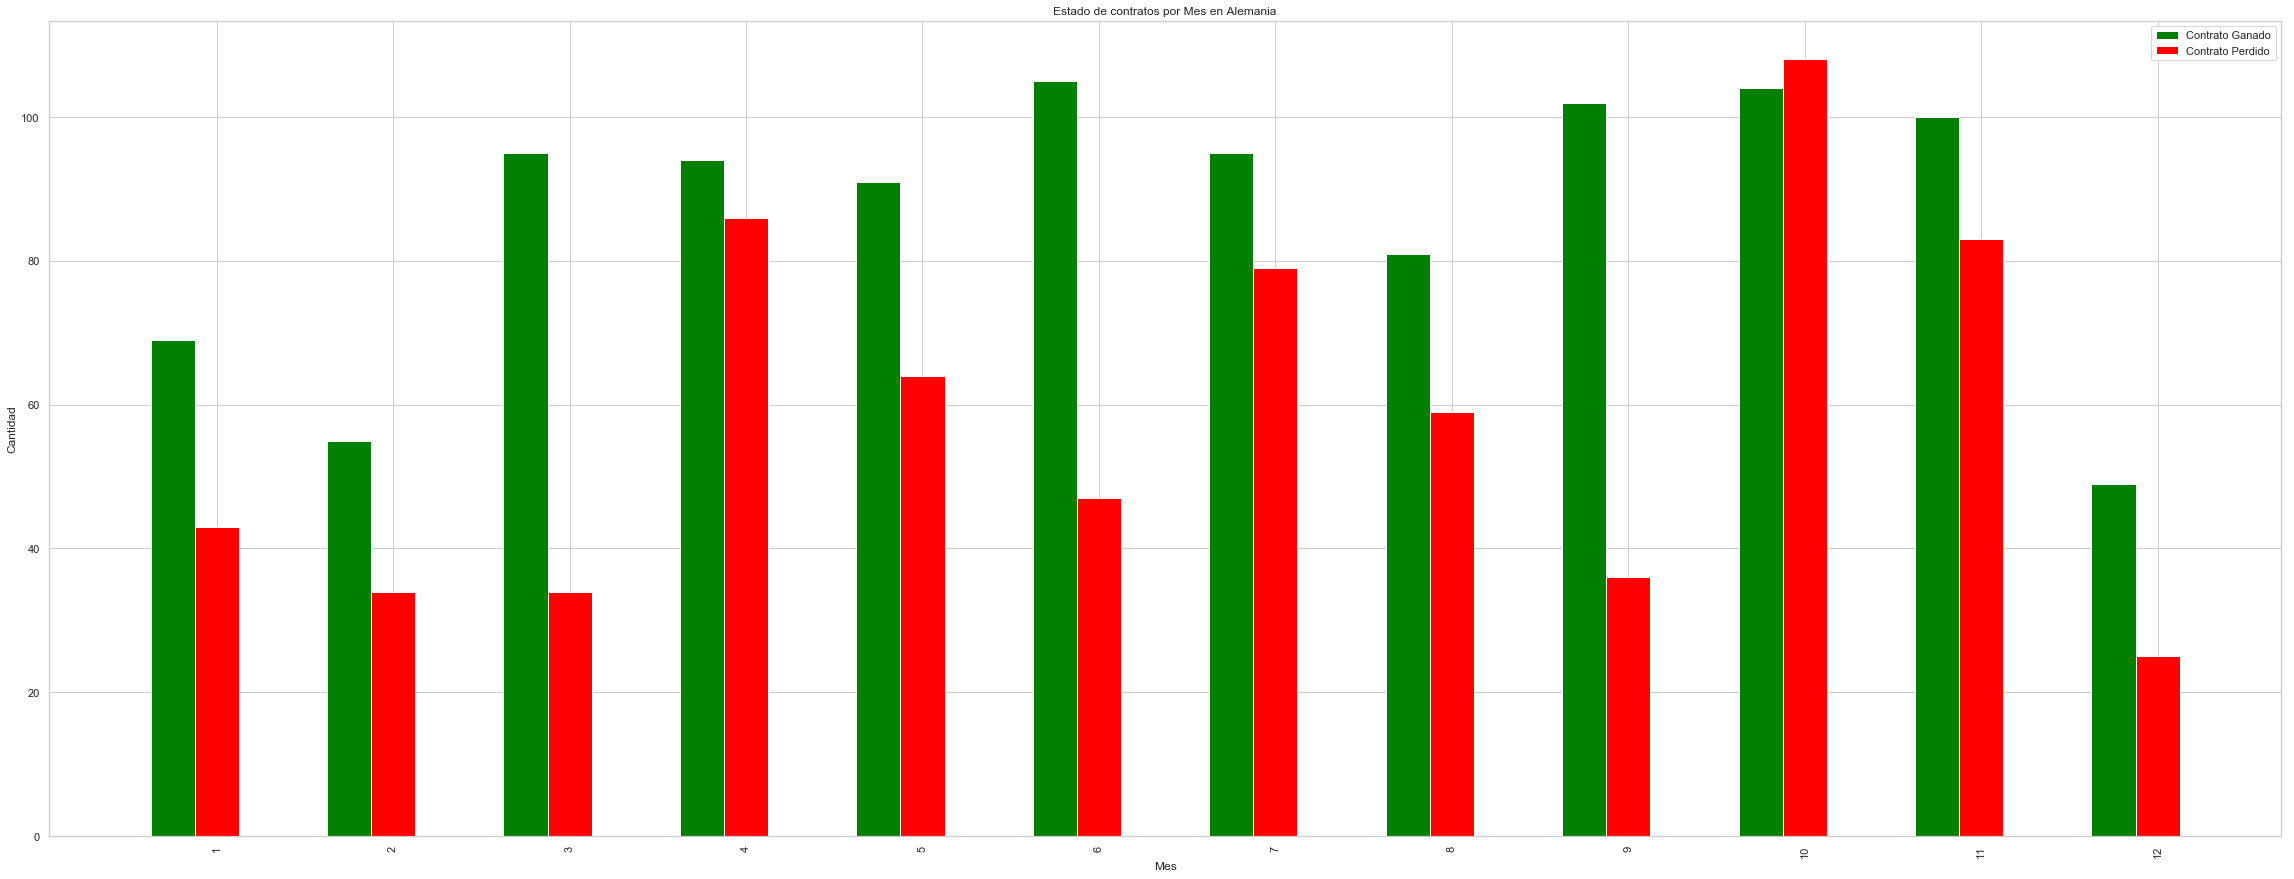

In [39]:
closed_contracts_germany = data[ ((data['Stage'] == "Closed Lost") | (data['Stage'] == "Closed Won")) & 
                        (data['Territory'] == "Germany") ]

data_by_germany_and_month = closed_contracts_germany.groupby(['Number_Month','Stage']).size()
data_by_germany_and_month = data_by_germany_and_month.unstack().reset_index().fillna(0)

# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_germany_and_month.shape[0])
width = 0.25

c_won = data_by_germany_and_month["Closed Won"].to_numpy()
c_lost = data_by_germany_and_month["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_germany_and_month['Number_Month'], rotation='vertical')
plt.title("Estado de contratos por Mes en Alemania")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

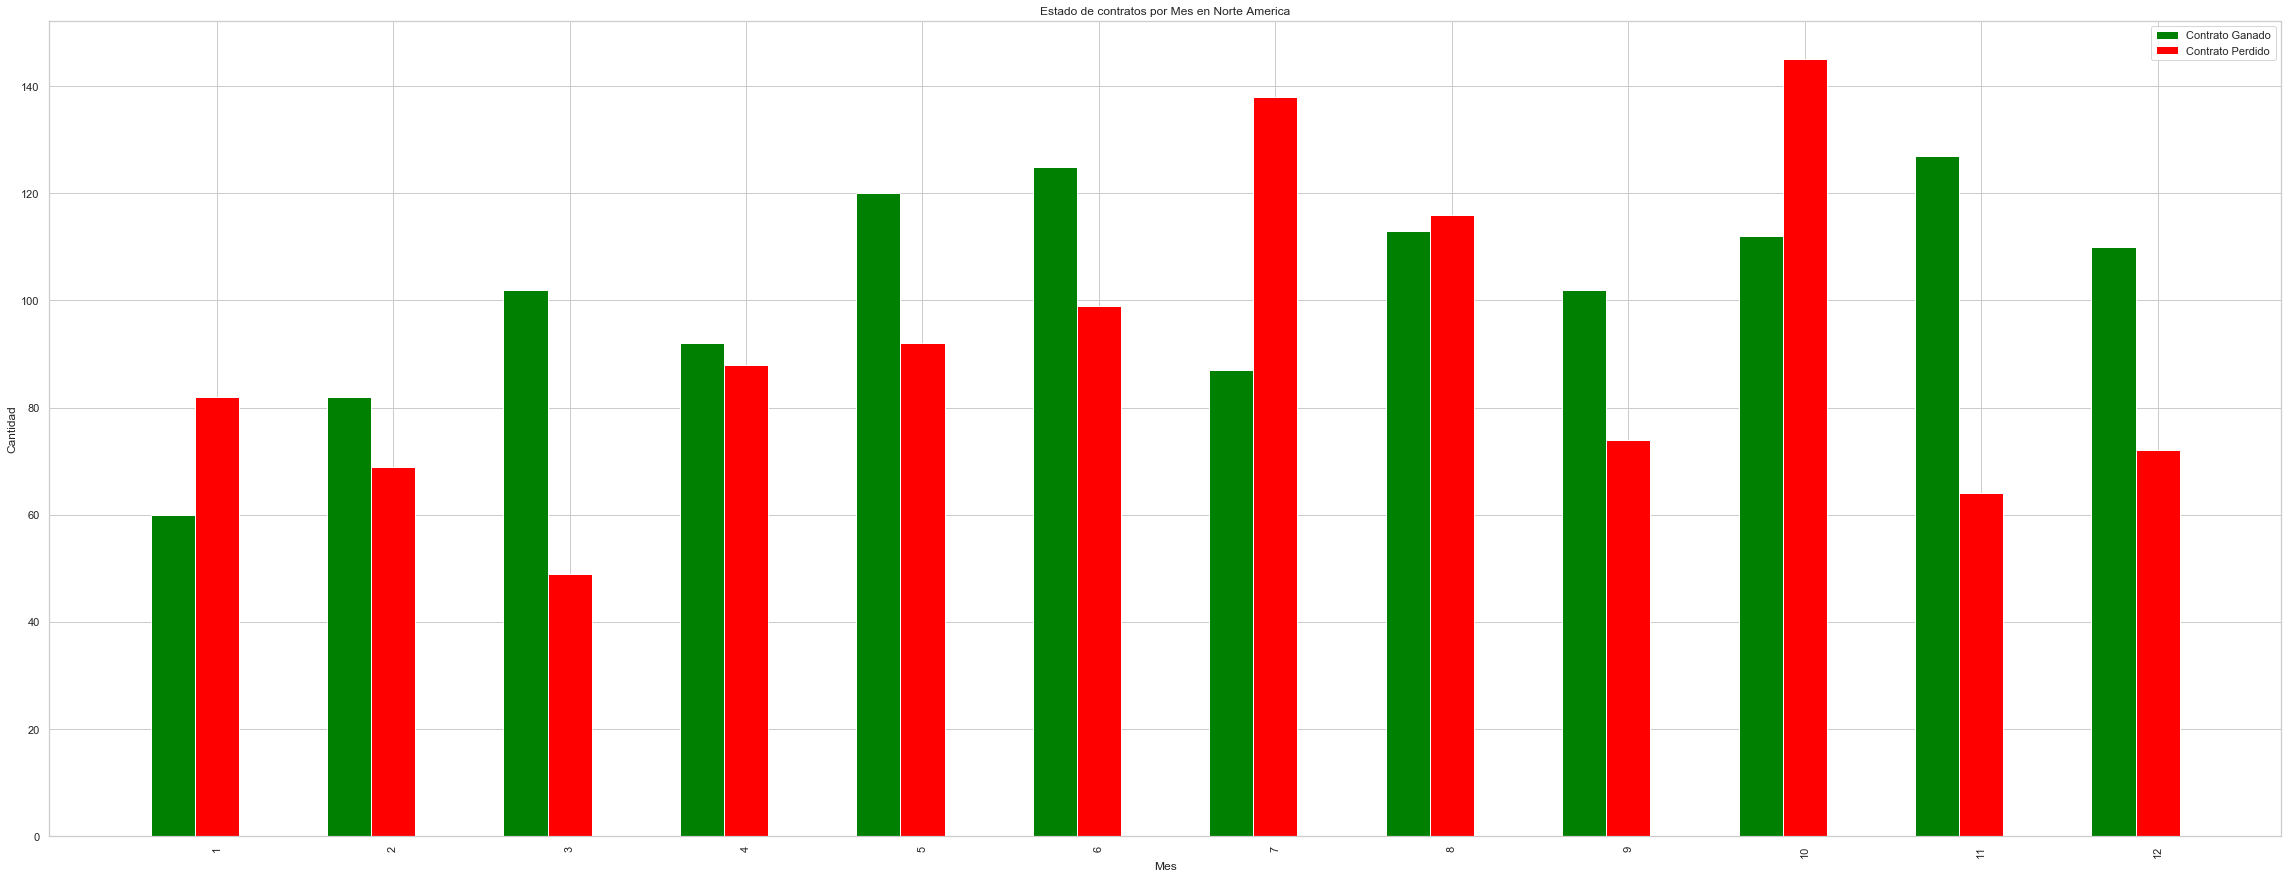

In [40]:
closed_contracts_north_america = data[ ((data['Stage'] == "Closed Lost") | (data['Stage'] == "Closed Won")) & 
                        ((data['Territory'] == "NW America") | (data['Territory'] == "NE America")) ]

data_by_namer_and_month = closed_contracts_north_america.groupby(['Number_Month','Stage']).size()
data_by_namer_and_month = data_by_namer_and_month.unstack().reset_index().fillna(0)

# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_namer_and_month.shape[0])
width = 0.25

c_won = data_by_namer_and_month["Closed Won"].to_numpy()
c_lost = data_by_namer_and_month["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_namer_and_month['Number_Month'], rotation='vertical')
plt.title("Estado de contratos por Mes en Norte America")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

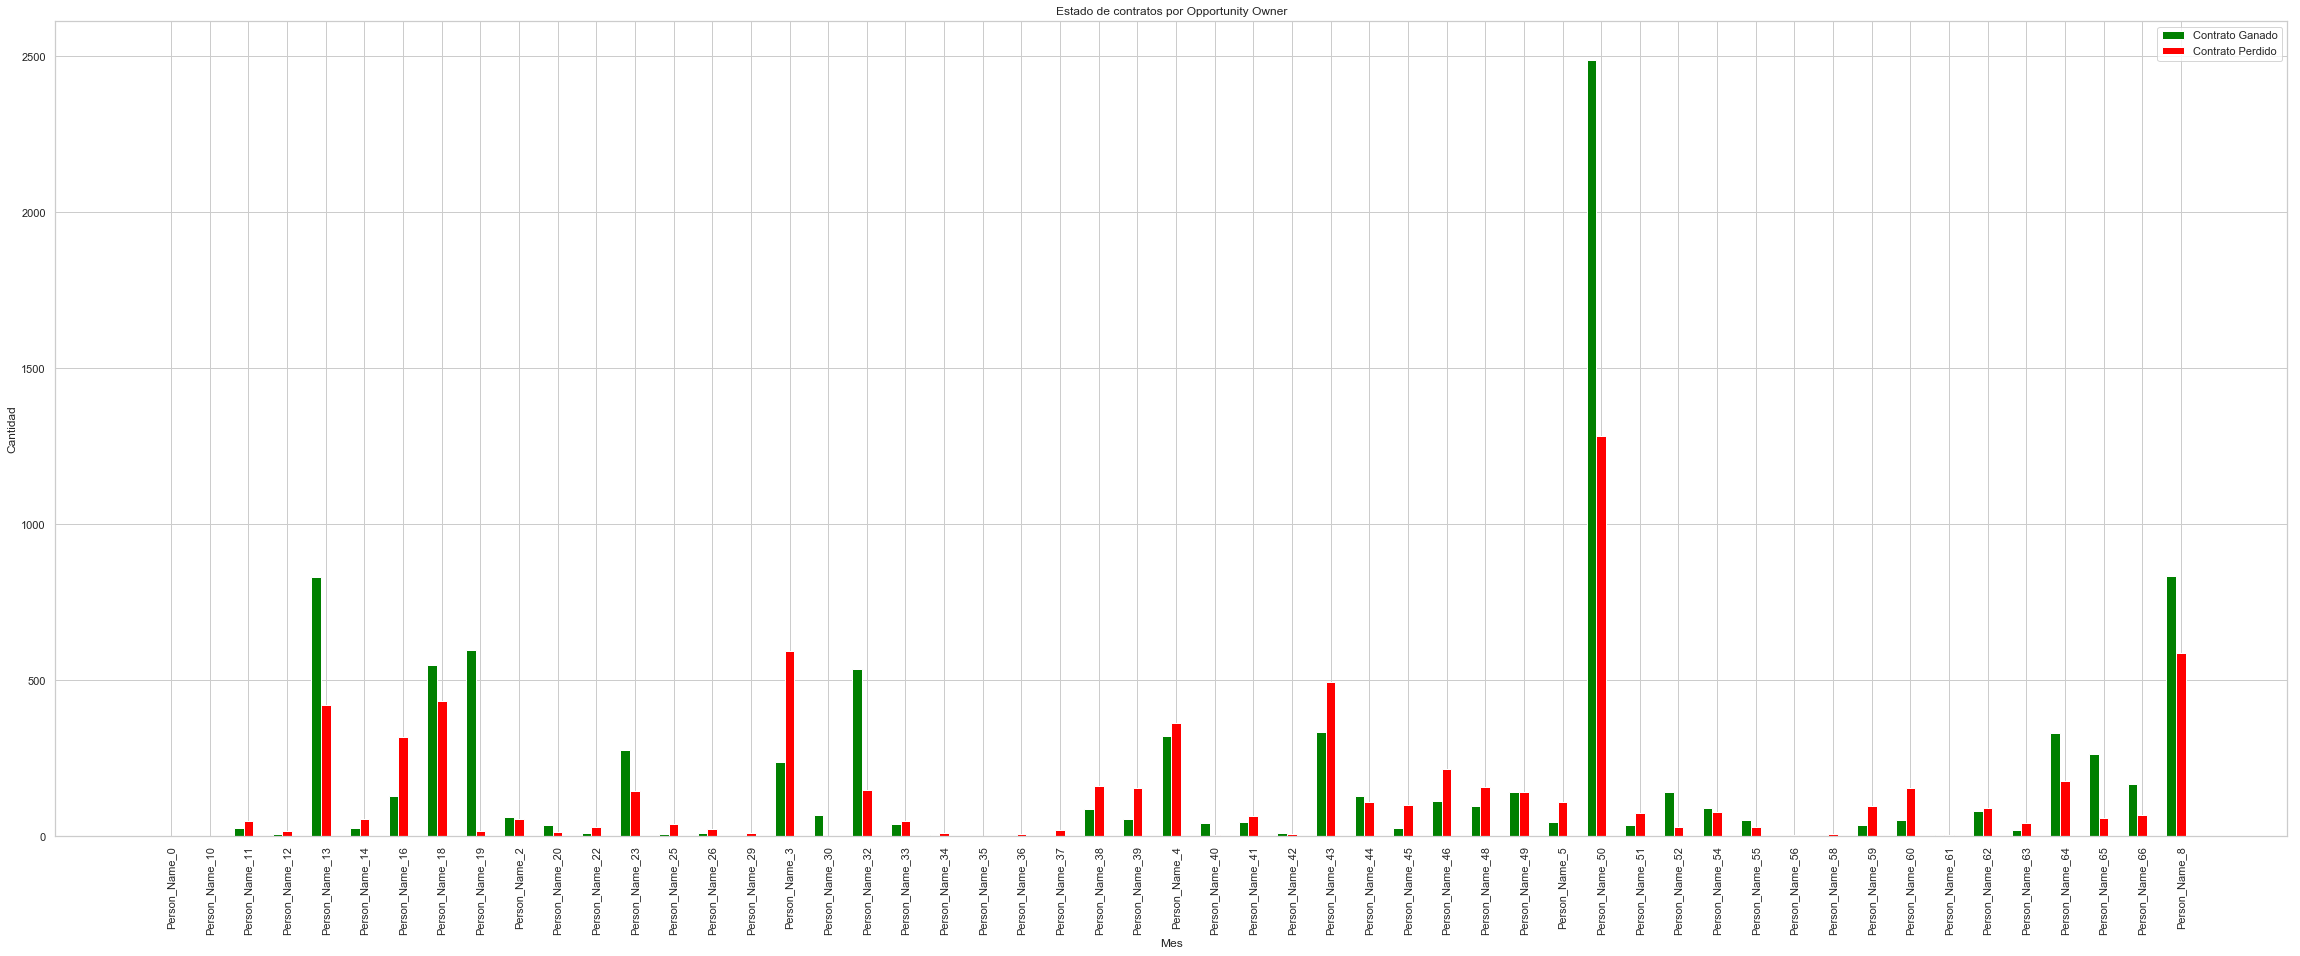

In [41]:
"""
Analisis por Opportunity Owner
"""

closed_contracts = data[ (data['Stage'] == "Closed Lost") | (data['Stage'] == "Closed Won") ]

data_by_op_owner = closed_contracts.groupby(['Opportunity_Owner','Stage']).size()
data_by_op_owner = data_by_op_owner.unstack().reset_index().fillna(0)

# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_op_owner.shape[0])
width = 0.25

c_won = data_by_op_owner["Closed Won"].to_numpy()
c_lost = data_by_op_owner["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_op_owner['Opportunity_Owner'], rotation='vertical')
plt.title("Estado de contratos por Opportunity Owner")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

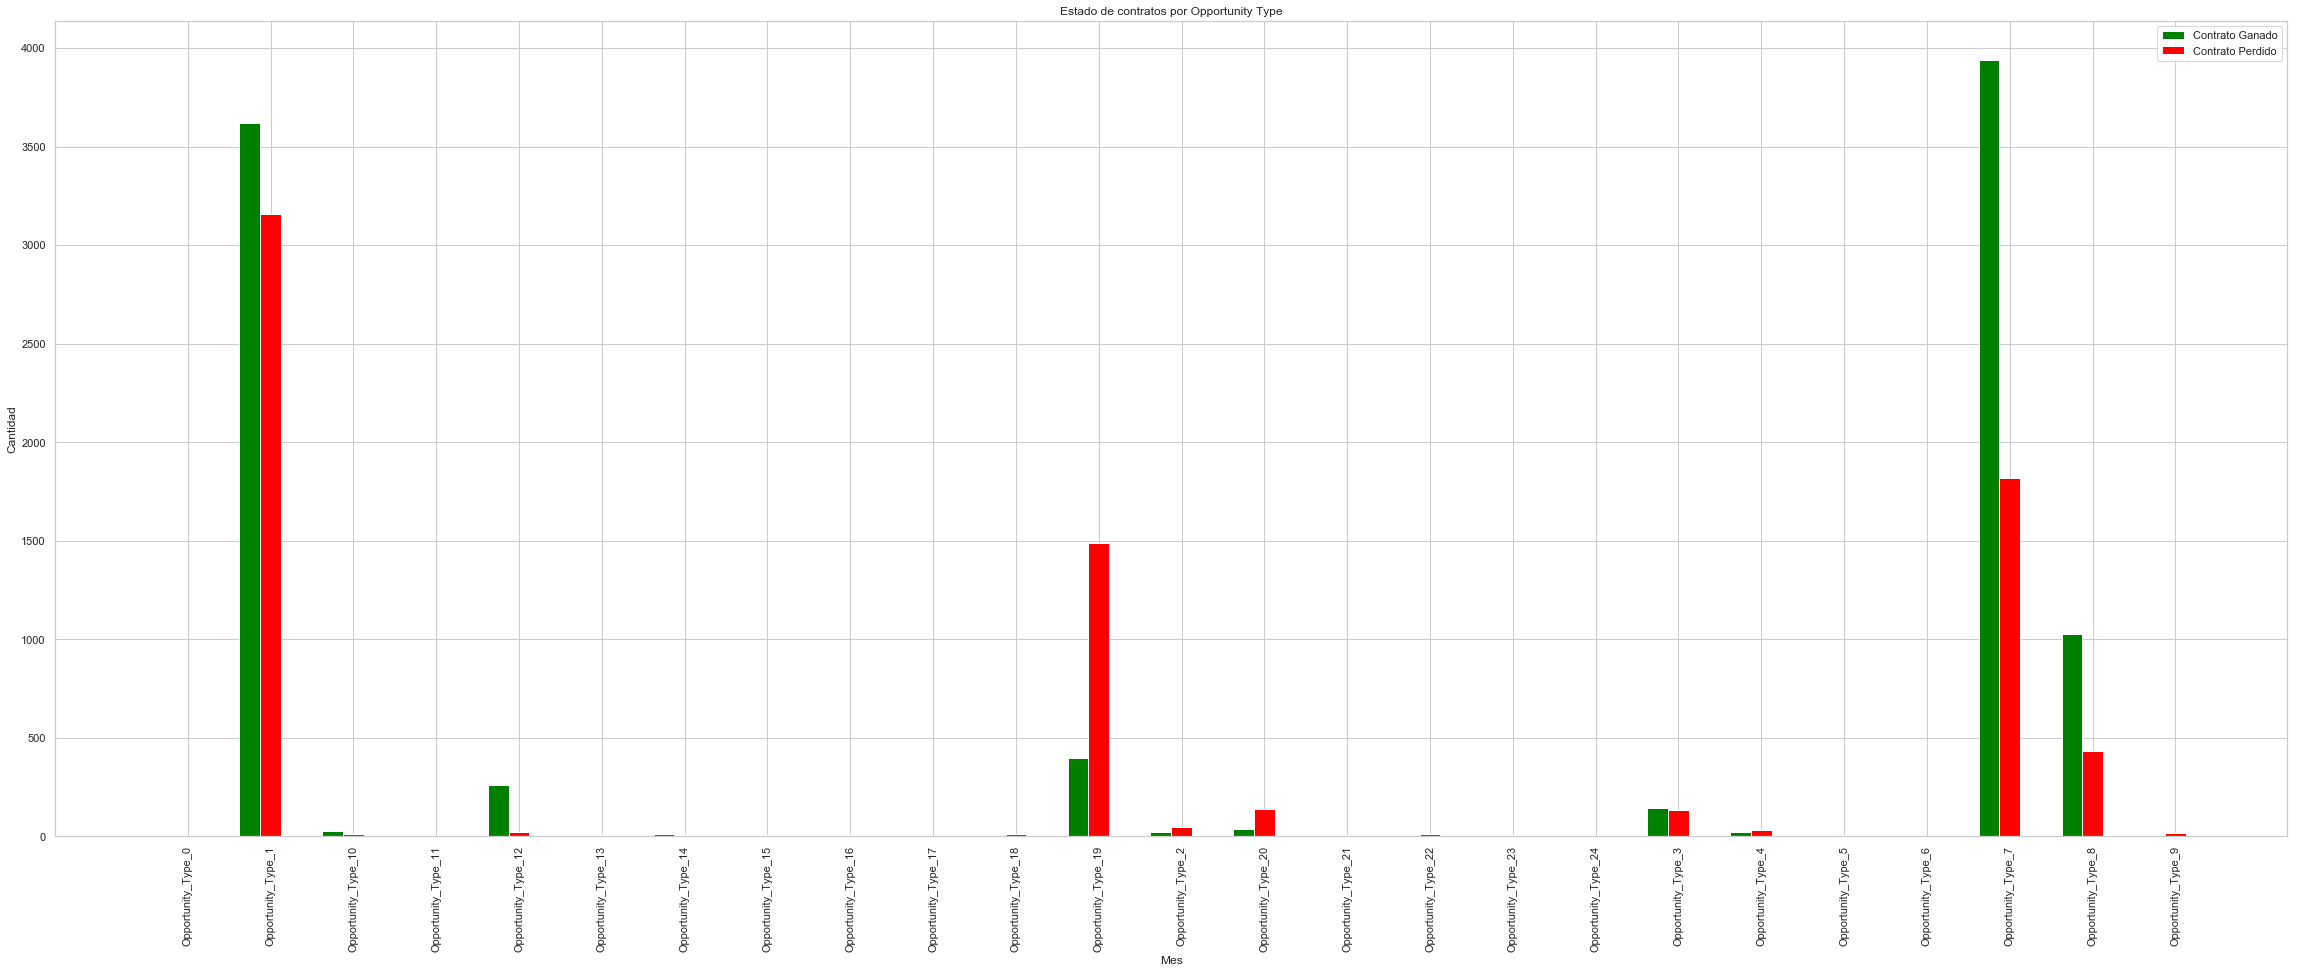

In [42]:
"""
Analisis por Opportunity Type
"""

closed_contracts = data[ (data['Stage'] == "Closed Lost") | (data['Stage'] == "Closed Won") ]

data_by_op_type = closed_contracts.groupby(['Opportunity_Type','Stage']).size()
data_by_op_type = data_by_op_type.unstack().reset_index().fillna(0)

# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_op_type.shape[0])
width = 0.25

c_won = data_by_op_type["Closed Won"].to_numpy()
c_lost = data_by_op_type["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_op_type['Opportunity_Type'], rotation='vertical')
plt.title("Estado de contratos por Opportunity Type")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

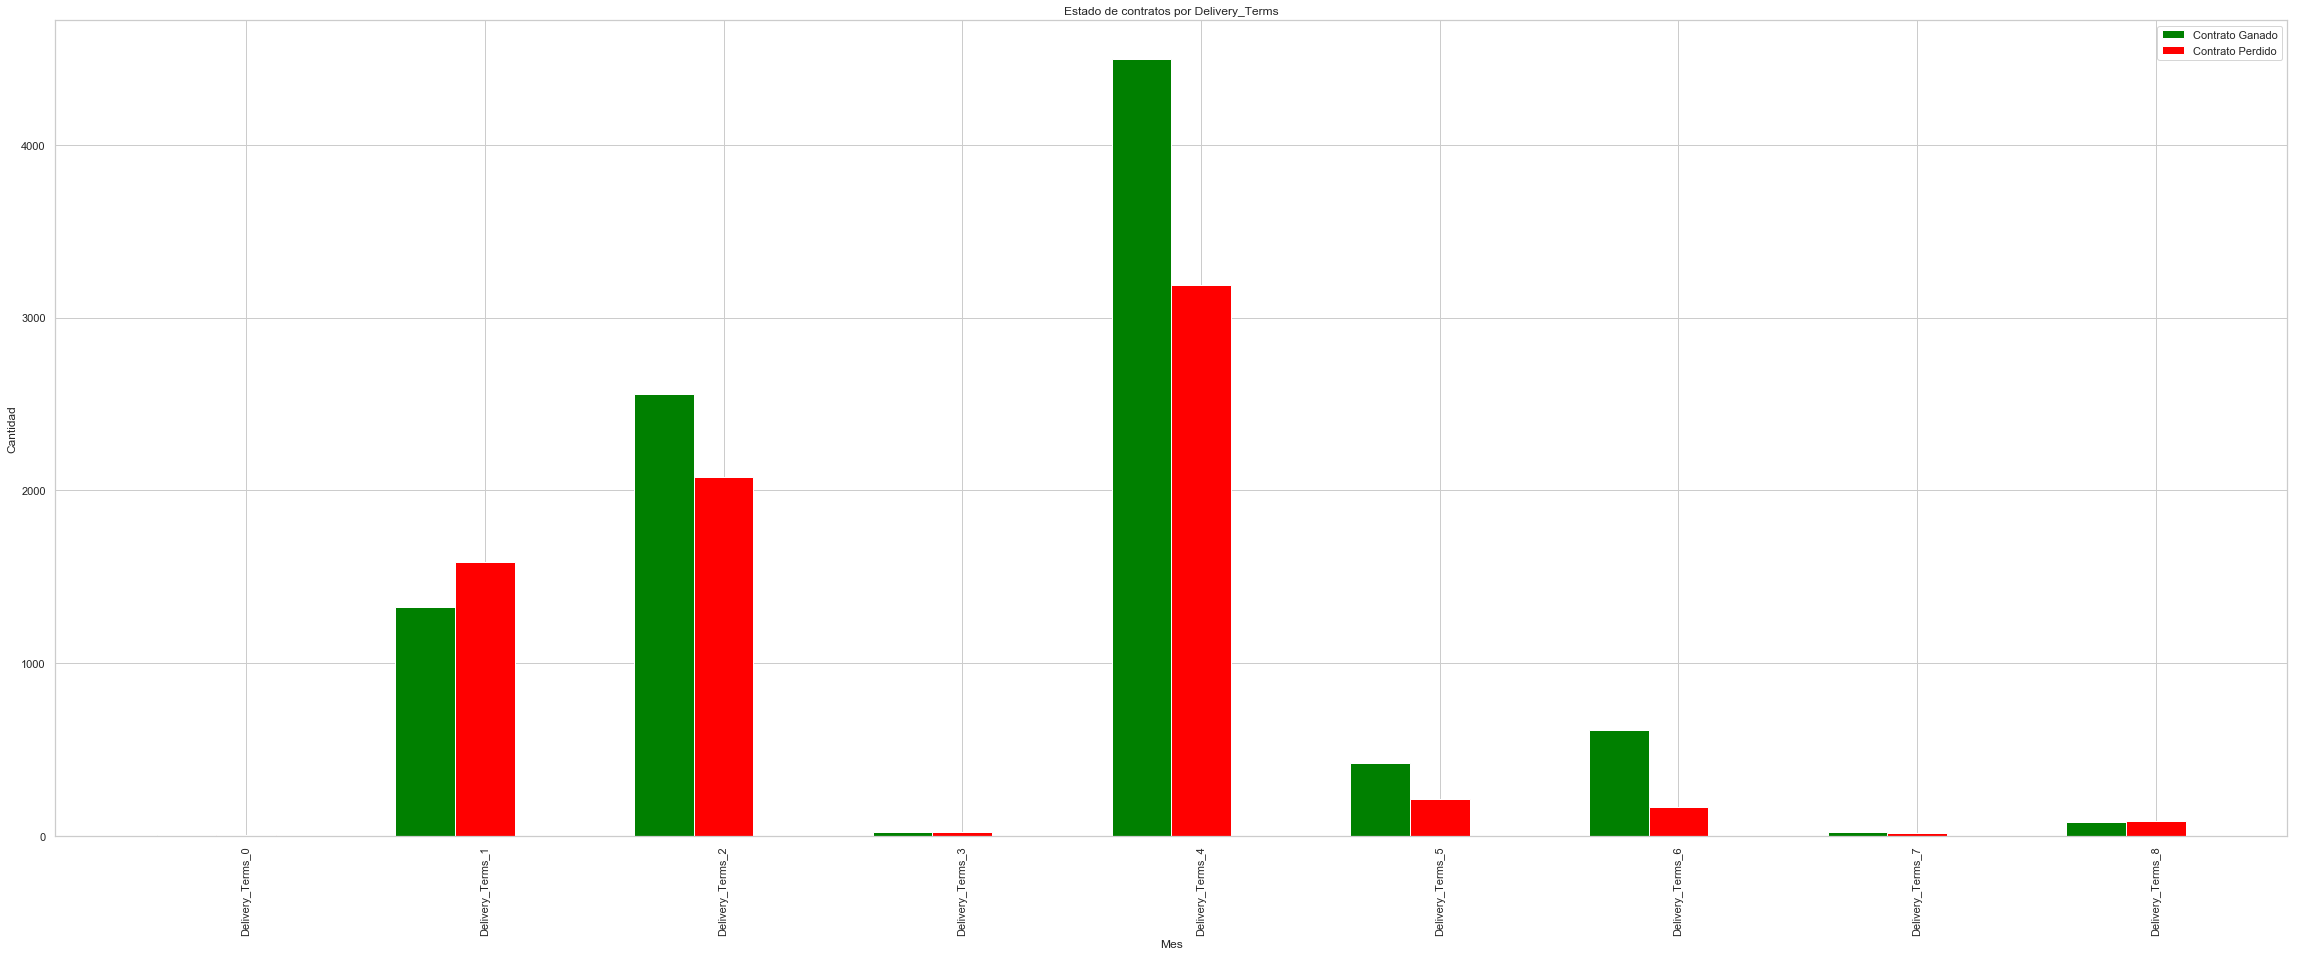

In [43]:
"""
Analisis por Delivery_Terms
"""

closed_contracts = data[ (data['Stage'] == "Closed Lost") | (data['Stage'] == "Closed Won") ]

data_by_del_terms = closed_contracts.groupby(['Delivery_Terms','Stage']).size()
data_by_del_terms = data_by_del_terms.unstack().reset_index().fillna(0)

# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_del_terms.shape[0])
width = 0.25

c_won = data_by_del_terms["Closed Won"].to_numpy()
c_lost = data_by_del_terms["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_del_terms['Delivery_Terms'], rotation='vertical')
plt.title("Estado de contratos por Delivery_Terms")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

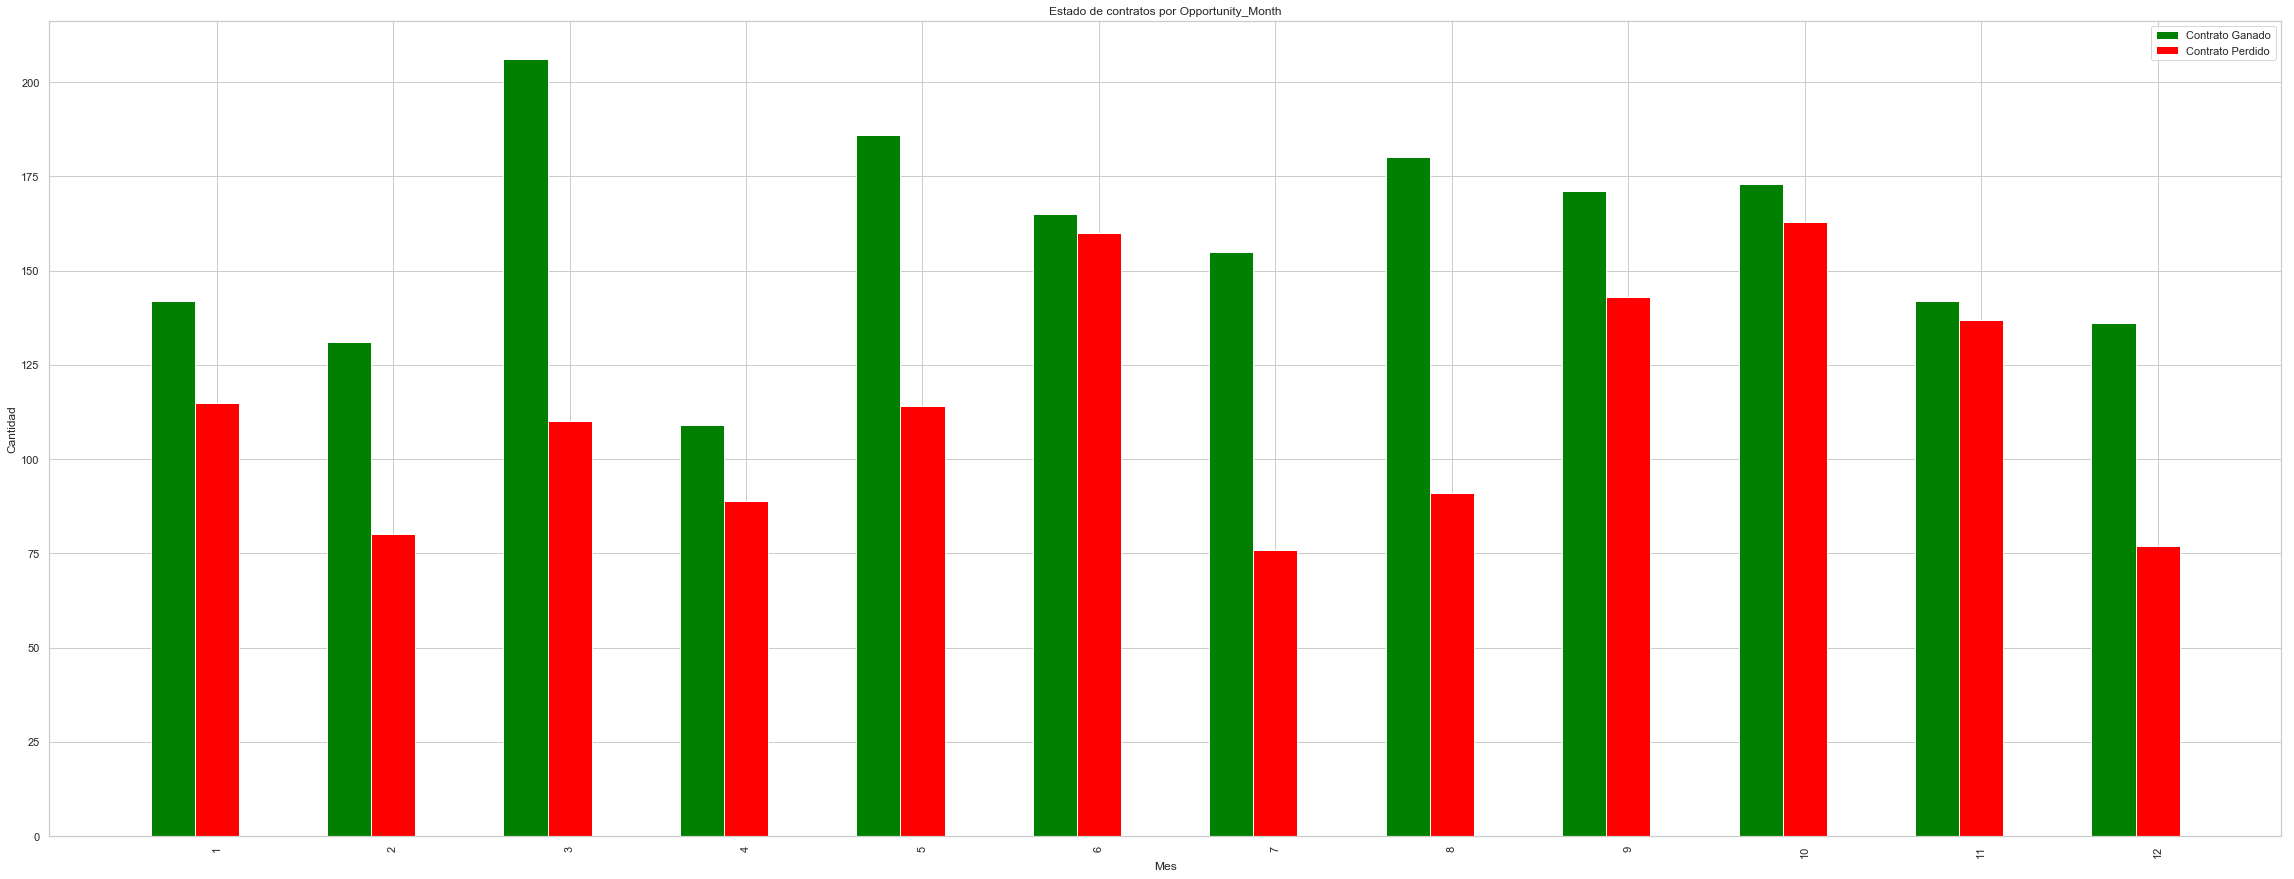

In [44]:
"""
Analisis por Opportunity_Month
"""
data['Opportunity_Month'] = pd.to_datetime(data['Opportunity_Created_Date']).dt.month
closed_contracts = data[ ((data['Stage'] == "Closed Lost") | (data['Stage'] == "Closed Won")) & 
                        (data['Region'] == "APAC") ]

data_by_emea_and_month = closed_contracts.groupby(['Opportunity_Month','Stage']).size()
data_by_emea_and_month = data_by_emea_and_month.unstack().reset_index().fillna(0)

# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_emea_and_month.shape[0])
width = 0.25

c_won = data_by_emea_and_month["Closed Won"].to_numpy()
c_lost = data_by_emea_and_month["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_emea_and_month['Opportunity_Month'], rotation='vertical')
plt.title("Estado de contratos por Opportunity_Month")
plt.xlabel("Mes")
plt.ylabel("Cantidad")
ax.legend()
plt.show()